OUTTA AI 부트캠프 딥러닝반 - Diffusion Pipeline

> StableDiffusionInpaintPipeline 설명

## Install

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> 일단 GOOGLE Drive 에 'GITS' 라는 폴더를 만드세요.

In [ ]:
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

/content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1772, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1772 (delta 2), reused 4 (delta 2), pack-reused 1766 (from 1)
Receiving objects: 100% (1772/1772), 124.81 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (822/822), done.
Updating files: 100% (234/234), done.


In [ ]:
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything

/content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━

## Imports

In [ ]:
%cd /content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything

/content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything


In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/content/drive/MyDrive/OUTTA/Project/Diffusion_실습/GITS/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


## (생략) Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-06-02 06:01:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  61.4MB/s    in 46s     

2024-06-02 06:02:30 (53.2 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Stable Diffusion (Inpainting)

> sd_pipe 설명

In [ ]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## (생략) Inference

In [ ]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "/content/drive/MyDrive/Colab Notebooks/1_Sams/src/girl_skirt1.png"
#image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

#download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

In [ ]:
image_source.shape #PIL 타입은 shape attribute 없다

## (생략) Grounding DINO for detection

In [ ]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


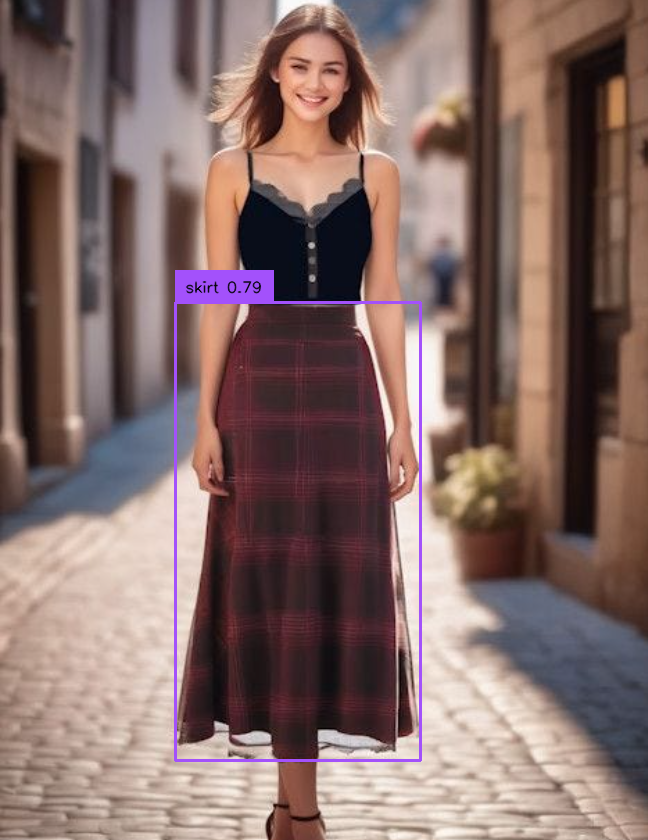

In [ ]:
annotated_frame, detected_boxes = detect(image, text_prompt="skirt", model=groundingdino_model)
Image.fromarray(annotated_frame)

## (생략) SAM for segmentation

> 인용구 추가



In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

NameError: name 'image_source' is not defined

## Stable Diffusion for inpainting

In [ ]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

NameError: name 'segmented_frame_masks' is not defined

> 이미지 생성 코드

In [ ]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

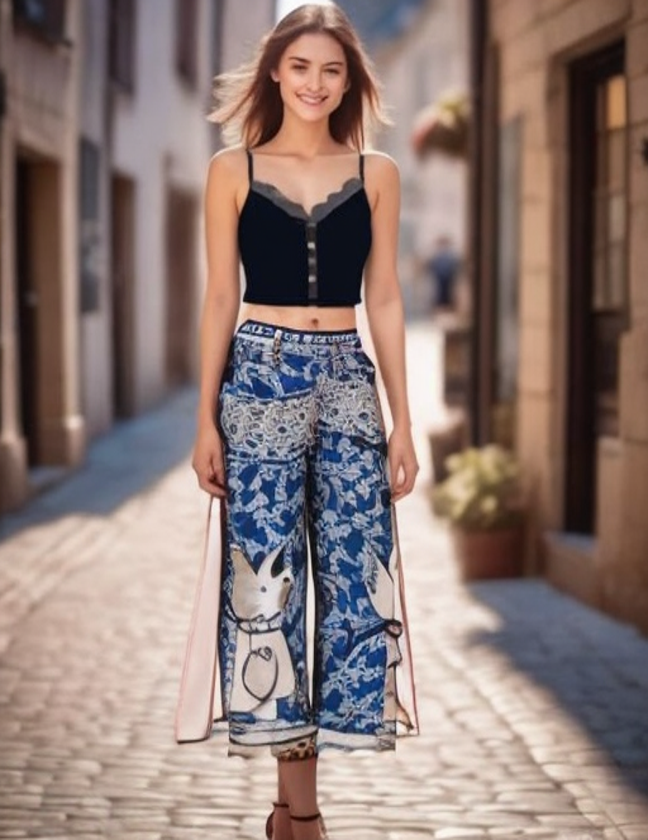

In [ ]:
prompt= "A blue pants, high quality, detailed, cute, with a lot of details"
# prompt= "A Red short skirt, high quality, detailed, cute, with a lot of details, ."
# prompt="---, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

# 부분 inpainting 예시

In [ ]:
text_prompt = input("찾고 싶은 객체를 입력하세요 : "시

찾고 싶은 객체를 입력하세요 : a girl


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


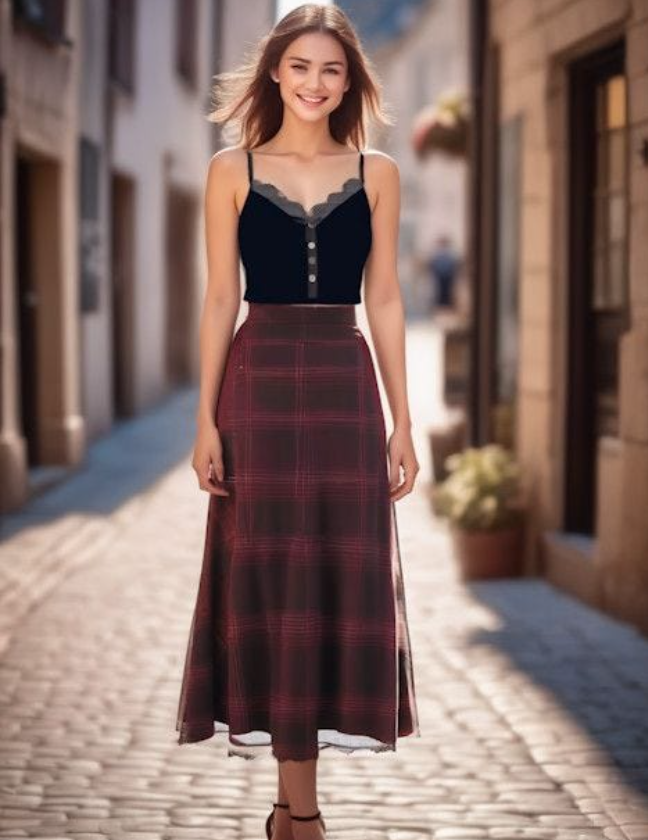

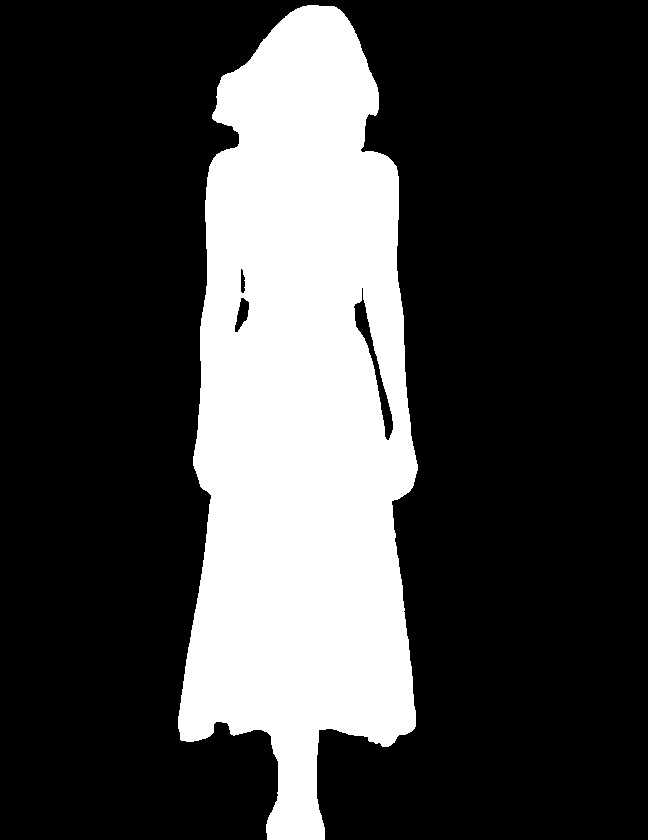

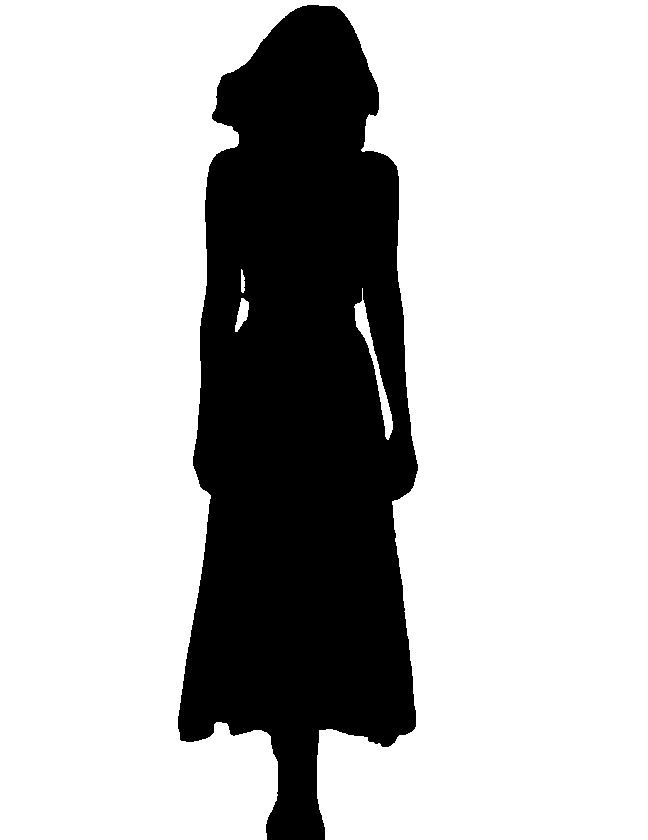

In [ ]:
annotated_frame, detected_boxes = detect(image, text_prompt=text_prompt, model=groundingdino_model)
Image.fromarray(annotated_frame)

segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

파일확장자를 포함한 이미지 파일명을 정확히 입력하세요 ex girl_skirt1.png: girl_skirt1.png
이미지내에서 찾고 싶은 객체를 입력하세요 ex.car : skirt
객체를 어떻게바꾸고 싶은지 입력하세요. ex.sports car : red short pants


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


  0%|          | 0/50 [00:00<?, ?it/s]

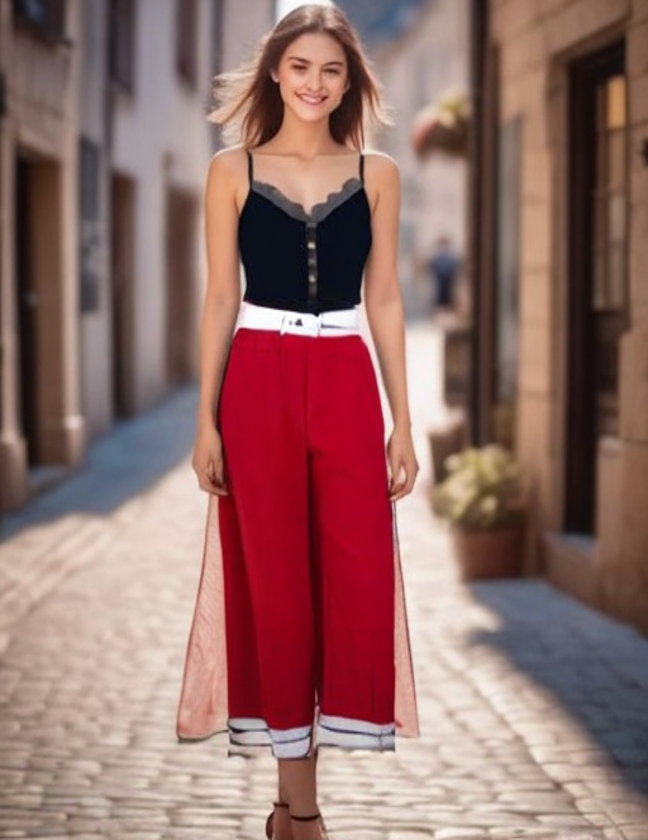

In [ ]:
folder_path1 = "/content/drive/MyDrive/Colab Notebooks/1_Sams/src/"

image_name = input("파일확장자를 포함한 이미지 파일명을 정확히 입력하세요 ex girl_skirt1.png: ")
image_source, image = load_image(folder_path1 + image_name)
Image.fromarray(image_source)

# ---------------------
text_prompt = input("이미지내에서 찾고 싶은 객체를 입력하세요 ex.car : ")
positive_prompt = input("객체를 어떻게바꾸고 싶은지 입력하세요. ex.sports car : ")
# "a girl who has two leg, a red hair, wearing a green skirt, high quality, detailed, cute, with a lot of details"


annotated_frame, detected_boxes = detect(image, text_prompt=text_prompt, model=groundingdino_model)
Image.fromarray(annotated_frame)

segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)

prompt = positive_prompt
negative_prompt = "low resolution, ugly"
seed = 1024 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image


파일확장자를 포함한 이미지 파일명을 정확히 입력하세요 ex girl_skirt1.png: girl_skirt1.png
이미지내에서 찾고 싶은 객체를 입력하세요 ex.car : skirt
객체를 어떻게바꾸고 싶은지 입력하세요. ex.sports car : red {{short}} pants


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


  0%|          | 0/50 [00:00<?, ?it/s]

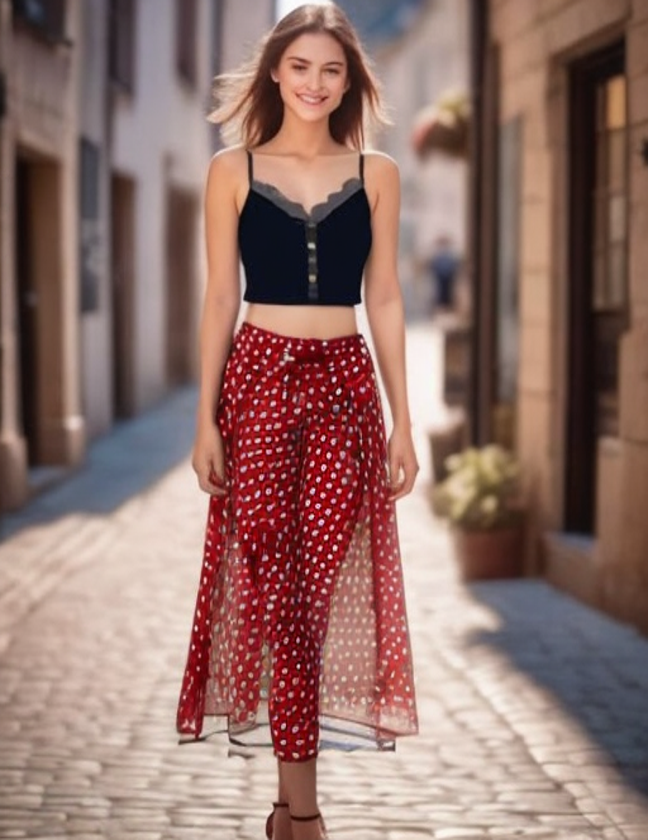

In [ ]:
folder_path1 = "/content/drive/MyDrive/Colab Notebooks/1_Sams/src/"

image_name = input("파일확장자를 포함한 이미지 파일명을 정확히 입력하세요 ex girl_skirt1.png: ")
image_source, image = load_image(folder_path1 + image_name)
Image.fromarray(image_source)

# ---------------------
text_prompt = input("이미지내에서 찾고 싶은 객체를 입력하세요 ex.car : ")
positive_prompt = input("객체를 어떻게바꾸고 싶은지 입력하세요. ex.sports car : ")
# "a girl who has two leg, a red hair, wearing a green skirt, high quality, detailed, cute, with a lot of details"


annotated_frame, detected_boxes = detect(image, text_prompt=text_prompt, model=groundingdino_model)
Image.fromarray(annotated_frame)

segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)

prompt = positive_prompt
negative_prompt = "low resolution, ugly"
seed = 30 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image
